In [1032]:
import numpy
import scipy.sparse
from scipy.sparse.linalg import spsolve

import quadpy

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import meshio
import igl

from aabbtree import AABB, AABBTree

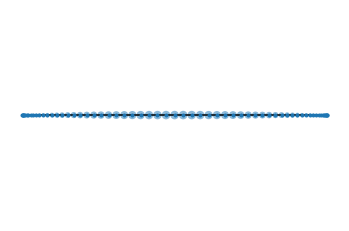

In [1033]:
# some quadrature rule
scheme = quadpy.c1.gauss_patterson(5)
scheme.show()

In [1034]:
def point_edge_coord(p, e0, e1):
    e = e1 - e0
    return (p - e0).dot(e) / e.dot(e)

def point_edge_distance(p, e0, e1):
    t = numpy.clip(point_edge_coord(p, e0, e1), 0, 1)
    d = p - ((e1 - e0) * t + e0)
    return d.dot(d)

def point_on_edge(p, e0, e1):
    return point_edge_distance(p, e0, e1) < 1e-8

## Meshes

In [1035]:
V_coarse = numpy.array([
    [0, 0, 0],
    [1, 0, 0],
    [1, 1, 0],
    [0, 1, 0],
], dtype=float)

E_coarse = numpy.array([
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 0],
])

m = V_coarse.shape[0]
n = 3
alphas = numpy.linspace(0, 1, n + 2)[1:-1]
V_fine = numpy.vstack(
    list(V_coarse) + 
    [(v1 - v0) * alpha + v0 for v0, v1 in V_coarse[E_coarse] for alpha in alphas]
)
# V_fine += 0.1 * numpy.random.random(V_fine.shape)

E_fine = []
for i in range(m):
    for j in range(n + 1):
        E_fine.append([
            i if j == 0 else (m - 1) + n * i + j, 
            ((i + 1) % m) if j == n else (m - 1) + n * i + j + 1])
E_fine = numpy.array(E_fine)

In [1036]:
coarse_mesh = meshio.read("../meshes/2D/kangaroo/kangaroo_coarse.msh")
V_coarse = coarse_mesh.points
E_coarse = igl.boundary_facets(coarse_mesh.cells[0].data.astype(int))
V_coarse, E_coarse, *_ = igl.remove_unreferenced(V_coarse, E_coarse[:, [0, 1, 1]])
E_coarse = E_coarse[:, :2]

fine_mesh = meshio.read("../meshes/2D/kangaroo/kangaroo_fine.msh")
V_fine = fine_mesh.points
E_fine = igl.boundary_facets(fine_mesh.cells[0].data.astype(int))
V_fine, E_fine, *_ = igl.remove_unreferenced(V_fine, E_fine[:, [0, 1, 1]])
E_fine = E_fine[:, :2]

print(V_coarse.shape, len(set(E_coarse.flatten())))
print(V_fine.shape, len(set(E_fine.flatten())))

(176, 3) 176
(314, 3) 314


In [1037]:
U_coarse = numpy.zeros(V_coarse.shape)
# U_coarse[V_coarse[:, 0] > 0.999, 1] = 1
U_coarse[:, 1] += numpy.sin(0.5 * numpy.pi * V_coarse[:, 0])
U_fine = numpy.zeros(V_fine.shape)
# U_fine[V_fine[:, 0] > 0.999, 1] = 1
U_fine[:, 1] += numpy.sin(0.5 * numpy.pi * V_fine[:, 0])

In [1038]:
coarse_coll = True
if coarse_coll:
    V_coll, V_fem = V_coarse, V_fine
    E_coll, E_fem = E_coarse, E_fine
    U_coll, U_fem = U_coarse, U_fine
else:
    V_coll, V_fem = V_fine, V_coarse
    E_coll, E_fem = E_fine, E_coarse
    U_coll, U_fem = U_fine, U_coarse

# V_fem = V_coll
# E_fem = E_coll
# U_fem = U_coll

## Upsample-Downsample Method

In [1039]:
def upsample(V, E, edge_splits):
    alphas = numpy.linspace(0, 1, edge_splits + 2)[1:-1]
    upsampled_V = [V]
    downsample_buddy = [[[i, 1]] for i in range(V.shape[0])]
    i= V.shape[0]
    for e in E:
        v0, v1 = V[e]
        for alpha in alphas:
            downsample_buddy[e[0]].append([i, 1-alpha])
            downsample_buddy[e[1]].append([i, alpha])
            upsampled_V.append((v1 - v0) * alpha + v0)
            i += 1
    return numpy.vstack(upsampled_V), downsample_buddy

In [1040]:
def compute_W(V_coll, V_fem, E_fem):
    W = numpy.zeros((V_coll.shape[0], V_fem.shape[0]))

    for i, v in enumerate(V_coll):
        ds = numpy.array([point_edge_distance(v, e0, e1) for e0, e1 in V_fem[E_fem]])
        ei = ds.argmin()
        e = E_fem[ei]
        e0, e1 = V_fem[e]
        t = numpy.clip(point_edge_coord(v, e0, e1), 0, 1)
        W[i, e[0]] = 1 - t
        W[i, e[1]] = t

    print(numpy.linalg.norm(V_coll - W @ V_fem))
    return W

In [1041]:
def downsample(W, downsample_buddies):
    W_downsampled = numpy.vstack([
        # W[i] + W[buddies].sum(axis=0)
        sum(weight * W[buddy] for buddy, weight in buddies)
        for buddies in downsample_buddies])
    W_downsampled /= W_downsampled.sum(axis=1)[:, None]
    return W_downsampled

In [1042]:
# edge_splits = 10
# V_coll_upsampled, downsample_buddy = upsample(V_coll, E_coll, edge_splits)
# W = compute_W(V_coll_upsampled, V_fem, E_fem)
# W_new = downsample(W, downsample_buddy)

## L2 Projection

In [1043]:
def hat_phi0(x):
    return 1-x
def hat_phi1(x):
    return x

In [1044]:
def build_bases(V, E):
    return [{
        "n_bases": 2,
        # 2 bases
        "phi": [hat_phi0, hat_phi1],
        # local to global mapping
        "loc_2_glob": e.tolist(),
        # geometric mapping
        "gmapping": lambda x, e=e: (V[e[1]] - V[e[0]]) * x + V[e[0]],
        "grad_gmapping": lambda _: numpy.linalg.norm(V[e[1]]-V[e[0]]),
    } for e in E]

In [1045]:
def compute_mass_mat(elements):
    rows, cols, vals = [], [], []
    
    # same as above but now we use phi instead of grad_phi and no division
    for el in elements:
        for i, phi_i in enumerate(el["phi"]):
            for j, phi_j in enumerate(el["phi"]):
                # ∫_{ŝ_j} ϕ̂ᵢ⋅ϕ̂ⱼ \,(s_{j, 1} - s_{j, 0})
                val = scheme.integrate(
                    lambda x: phi_i(x) * phi_j(x) * el["grad_gmapping"](x),
                    [0.0, 1.0])

                rows.append(el["loc_2_glob"][i])
                cols.append(el["loc_2_glob"][j])
                vals.append(val)

    return scipy.sparse.coo_matrix((vals, (rows, cols))).tocsc()
    

In [1046]:
def compute_mass_mat_cross(a, b, poly_b, e_b, shape):
    rows, cols, vals = [], [], []
    
    q_pts = (scheme.points+1)/2 # [-1, 1] -> [0, 1]
    q_w = scheme.weights/2 # sum(w) = 2 -> sum(w) = 1
    
    # Build a tree for fast interior checks
    tree = AABBTree()
    for ei, e in enumerate(e_b):
        limits = numpy.vstack([poly_b[e].min(axis=0), poly_b[e].max(axis=0)]).T
        tree.add(AABB(limits), ei)

    for el in a:
        for i in range(el["n_bases"]):
            others = {}
            
            for q in range(len(q_w)):
                t = q_pts[q]
                w = q_w[q]
                
                pt = el["gmapping"](t)
                bb = find_and_eval(pt, b, poly_b, e_b, tree)
                
                for j in bb:
                    if j[0] in others:
                        others[j[0]] += w*j[1]*el["phi"][i](t) * el["grad_gmapping"](t)
                    else:
                        others[j[0]] = w*j[1]*el["phi"][i](t) * el["grad_gmapping"](t)
            
            for j in others:
                rows.append(el["loc_2_glob"][i])
                cols.append(j)
                vals.append(others[j])

    assert(len(set(rows)) == shape[0])
    assert(len(set(cols)) == shape[1])
    return scipy.sparse.coo_matrix((vals, (rows, cols))).tocsc()

In [1047]:
A = V_coll[:, 0:2]
E_A = E_coll
B = V_fem[:, 0:2]
E_B = E_fem

In [1048]:
A_bases = build_bases(A, E_A)
B_bases = build_bases(B, E_B)

In [1049]:
MM = compute_mass_mat(A_bases)

In [1050]:
M = compute_mass_mat_cross(A_bases, B_bases, B, E_B, [A.shape[0], B.shape[0]])

In [1051]:
M.shape, MM.shape

((176, 314), (176, 176))

In [1069]:
def print_density(A):
    print(f"{(A.nnz / numpy.product(A.shape)) * 100:.2f}%")

def eliminate_near_zeros(A, tol=1e-12):
    A.data[numpy.abs(A.data) < tol] = 0
    A.eliminate_zeros()

MM_lumped = scipy.sparse.csc_matrix(MM.shape)
MM_lumped.setdiag(MM.sum(axis=1))

# W = spsolve(MM, M)
W = spsolve(MM, M)
eliminate_near_zeros(W)
print_density(W)

W_lumped = spsolve(MM_lumped, M)
eliminate_near_zeros(W_lumped)
print_density(W_lumped)

W_CG = scipy.sparse.lil_matrix(W.shape).A
for col in range(M.shape[1]):
    # print(M[:, col])
    W_CG[:, col], info = scipy.sparse.linalg.cg(MM, M.A[:, col])
W_CG = scipy.sparse.csc_matrix(W_CG)
eliminate_near_zeros(W_CG)
print_density(W_CG)

22.81%
1.73%
10.81%


In [1053]:
print_density(M)
print_density(MM)

1.73%
1.70%


In [1054]:
def check_unity(W, tol=1e-11):
    return (abs(W.sum(axis=1) - 1) < tol).all()

print(check_unity(W), check_unity(W_lumped))

True True


## Visualization

In [1055]:
def MeshTrace(V, E, mode="markers+lines", name=""):
    segments_x = []
    segments_y = []
    for e in E:
        segments_x.extend(V[e, 0].tolist() + [None])
        segments_y.extend(V[e, 1].tolist() + [None])
    return go.Scatter(x=segments_x, y=segments_y, mode=mode, name=name)

In [1067]:
X_coll = V_coll + W @ U_fem
X_coll_lumped = V_coll + W_lumped @ U_fem
X_coll_CG = V_coll + W_CG @ U_fem
X_fem = V_fem + U_fem

fig = make_subplots(rows=1, cols=2)

fig.add_trace(MeshTrace(V_fem, E_fem, name="V_fem"), row=1, col=1)
fig.add_trace(MeshTrace(V_coll, E_coll, name="V_coll"), row=1, col=1)
fig.add_trace(MeshTrace(X_fem, E_fem,  mode="lines", name="Deformed V_fem"), row=1, col=2)
fig.add_trace(MeshTrace(X_coll, E_coll,  mode="lines", name="Deformed V_coll"), row=1, col=2)
fig.add_trace(MeshTrace(X_coll_lumped, E_coll,  mode="lines", name="Deformed (lumped) V_coll"), row=1, col=2)
fig.add_trace(MeshTrace(X_coll_lumped, E_coll,  mode="lines", name="Deformed (CG) V_coll"), row=1, col=2)

fig.update_layout(width=1500, height=750, title="Displace V_fem")
fig.update_yaxes(scaleanchor="x", scaleratio=1)

In [1057]:
X_coll = V_coll + U_coll
X_fem = V_fem + W.T @ U_coll
X_fem_lumped = V_fem + W_lumped.T @ U_coll

fig = make_subplots(rows=2, cols=2)

fig.add_trace(MeshTrace(V_coll, E_coll, name="V_coll"), row=1, col=1),
fig.add_trace(MeshTrace(V_fem, E_fem, name="V_fem"), row=1, col=2),
fig.add_trace(MeshTrace(X_coll, E_coll, name="Deformed V_coll"), row=2, col=1),
fig.add_trace(MeshTrace(X_fem, E_fem, name="Deformed V_fem"), row=2, col=2),
fig.add_trace(MeshTrace(X_fem_lumped, E_fem, name="Deformed (lumped) V_fem"), row=2, col=2),

fig.update_layout(width=800, height=800, title="Displace V_fem")

None